In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
# from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

MAX_ROWS = None # 25000 # None # 10000
VISUALIZE = False

print('ready')

ready


In [2]:
def make_readable(label):
    return re.sub("([a-z])([A-Z])","\g<1> \g<2>",label)

**read_data_small** is the function to read in the small dataset about 30 MB

In [3]:
def read_data_small(max_rows):
    X_train = pd.read_csv("data_small/X_train_small.csv")
    X_test = pd.read_csv("data_small/X_test_small.csv")
    y_train = np.asarray(pd.read_csv("data_small/y_train_small.csv", header=None)[0])
    if max_rows:
        # Take random subset of rows
        
        rows = np.random.choice(np.arange(len(X_train)), max_rows, False)
        print(X_train.shape, X_test.shape, len(y_train))
        print('random rows', rows)
        return X_train.iloc[rows], X_test, y_train[rows]
#         return X_train[:max_rows], X_test[:max_rows], y_train[:max_rows]
    return X_train, X_test, y_train

**read_data_big** is the function to read in the big dataset about 100 MB

In [4]:
def read_data_big(max_rows):
    X_train = pd.read_csv("data_big/X_train_big.csv")
    X_test = pd.read_csv("data_big/X_test_big.csv")
    y_train = np.asarray(pd.read_csv("data_big/y_train_big.csv", header=None)[0])
    return X_train, X_test, y_train

**read_data** is the function to read in the whole dataset about 1.5 G

In [5]:
def read_data(max_rows):
    X_train = pd.read_csv("data/X_train.csv")
    X_test = pd.read_csv("data/X_test.csv")
    y_train = np.asarray(pd.read_csv("data/y_train.csv", header=None)[0])
    return X_train, X_test, y_train

In [6]:
def read_data_wrapper(max_rows=None):
    # return one of: read_data, read_data_big, read_data_wrapper
    return read_data_small(max_rows)

# Insert Your Code Here

**detect_spoofying** is the function for training the classifier and classify the results. 

Here we provide an simple example.

In [7]:
X_train, X_test, y_train = read_data_wrapper(MAX_ROWS)
print(X_train.info())

(141822, 29) (60782, 29) 141822
random rows [ 50182  84487  28978 ... 115093  98215  41929]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 50182 to 41929
Data columns (total 29 columns):
timestamp        25000 non-null int64
type             25000 non-null object
obId             25000 non-null object
member           25000 non-null object
user             25000 non-null object
endUserRef       25000 non-null object
price            25000 non-null float64
volume           25000 non-null float64
operation        24193 non-null object
isBid            24193 non-null object
orderId          24193 non-null object
source           24193 non-null object
tradeId          807 non-null object
bidOrderId       807 non-null object
askOrderId       807 non-null object
isBuyer          807 non-null object
isAggressor      807 non-null object
bestBid          24999 non-null float64
bestBidVolume    24999 non-null float64
bestAsk          24997 non-null float64
bestAskVolume    2499

In [8]:
# X_train.info()
print(len(set(X_train['user'])))
# set(X_train['type'])
print(len(set(X_train['member'])))

223
66


In [9]:
NUMERIC_COLS = ["price","volume","bestBid","bestAsk",'bestBidVolume',
                    'bestAskVolume','lv2Bid', 'lv2BidVolume','lv2Ask', 
                    'lv2AskVolume', 'lv3Bid', 'lv3BidVolume', 'lv3Ask',
                    'lv3AskVolume']
ENCODED_COLS = ['member', 'user']


In [10]:
### import libraries here ###
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_validate

### code classifier here ###
# Feature engineering
def format_data(df):

    cols = []
    cols.extend(NUMERIC_COLS)
    cols.extend(ENCODED_COLS)
    
    # append numberical columns
    rst = df.loc[:, cols]
    
    # encode the binaries
    rst["isBid"] = df.isBid*1
    rst["isBuyer"] = df.isBuyer*1
    rst["isAggressor"] = df.isAggressor*1
    rst["type"] = (df.type == "ORDER")*1
    rst["source"] = (df.source=="USER")*1

    # parse the order id data
    rst["orderId"] = df.orderId.str.split('-').str[-1]
    rst["tradeId"] = df.tradeId.str.split('-').str[-1]
    rst["bidOrderId"] = df.bidOrderId.str.split('-').str[-1]
    rst["askOrderId"] = df.askOrderId.str.split('-').str[-1]
    
    
    # encode the multiple label data
    tmp_operation = pd.DataFrame(pd.get_dummies(df.operation, prefix="op"), columns=df.operation.unique()[:-1])
    rst = pd.concat([rst, tmp_operation], axis=1)
#     tmp_endUserRef = pd.DataFrame(pd.get_dummies(df.endUserRef, prefix="enduser"), columns=df.endUserRef.unique()[:-1])
#     rst = pd.concat([rst, tmp_endUserRef], axis=1)
    
    # also feel free to add more columns inferred from data
    # smartly engineered features can be very useful to improve the classification results
    rst["timeSinceLastTrade"] = X_train[["timestamp","endUserRef"]].groupby("endUserRef").diff()

    for col in ENCODED_COLS:
        # https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
        # one hot encode
        # Get one hot encoding of columns B
        one_hot = pd.get_dummies(df[col], prefix=col)
        # Drop column B as it is now encoded
        rst = rst.drop(col, axis = 1)
        # Join the encoded df
        rst = rst.join(one_hot)
    print('data shape', rst.shape)
    print('cols', len(rst.columns.values))
    return rst

def get_scaled_data(X_train, X_test, y_train):
        
    # clean up the data
#     df = df[~df.index.duplicated()]
    X_clean = format_data(pd.concat([X_train, X_test]))
    for c in NUMERIC_COLS:
        X_clean[c]= X_clean[c].fillna(X_clean[c].mean())
#     X_clean.fillna(method='ffill', inplace=True)
    X_clean = X_clean.fillna(-1)
#     print(X_clean.mean())
    # X_clean.fillna(-1)
    
    feature_columns = X_clean.columns.values

    X_train_clean = X_clean.iloc[:X_train.shape[0],:]
    X_test_clean = X_clean.iloc[X_train.shape[0]:,:]
    X_train_clean_scaled = scale(X_train_clean)
    X_test_clean_scaled = scale(X_test_clean)
    return X_train_clean_scaled, X_test_clean_scaled, y_train, feature_columns

# Classification algorithm
def detect_spoofying(X_train, X_test, y_train):
    X_train_clean_scaled, X_test_clean_scaled, y_train, feature_columns = get_scaled_data(X_train, X_test, y_train)
    
    clf = ExtraTreesClassifier() # .89
#     clf = LinearSVC(random_state=0, tol=1e-5, multi_class="crammer_singer")
#     clf = KNeighborsClassifier(n_neighbors=3)
    

    # fit classifier
#     clf = LogisticRegression(random_state=0, class_weight='balanced')
    clf.fit(X_train_clean_scaled, y_train)
    # print('features', list(zip(feature_columns, clf.feature_importances_)))
    y_train_prob_pred = clf.predict_proba(X_train_clean_scaled)
    y_test_prob_pred = clf.predict_proba(X_test_clean_scaled)
    
    return y_train_prob_pred, y_test_prob_pred

In [11]:
if VISUALIZE:
    X_train, X_test, y_train = read_data_wrapper(MAX_ROWS)
    X_train_clean_scaled, X_test_clean_scaled, y_train, feature_columns = get_scaled_data(X_train, X_test, y_train)

    clf = ExtraTreesClassifier()

    # fit classifier
    #     clf = LogisticRegression(random_state=0, class_weight='balanced')
    clf.fit(X_train_clean_scaled, y_train)
    print('features', list(zip(feature_columns, clf.feature_importances_)))


In [12]:
if VISUALIZE:
    names = feature_columns
    values = clf.feature_importances_
    zipped = zip(names, values)
    res = sorted(zipped, key = lambda x: x[1], reverse=True)

    n = 50
    names = [make_readable(i[0]) for i in res[:n]]
    values = [i[1] for i in res[:n]]

    plt.figure(figsize=(16, 9))
    sns.barplot(values, names)

    plt.title('Feature Importance')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.show()

In [13]:
X_num = X_train.loc[:, NUMERIC_COLS]

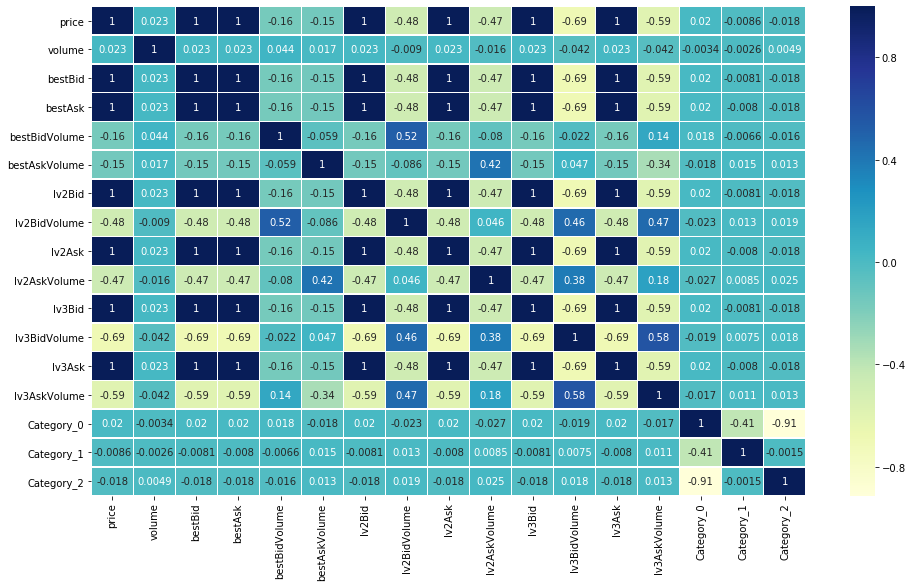

In [14]:
X_num.describe()
# set(y_train)
y_categories = pd.get_dummies(pd.DataFrame(y_train).replace({0: '0', 1: '1', 2: '2'}),prefix='Category')
# print(y_categories.loc[y_categories['0_Category 1'] == 1])
corr_df = X_num.join(y_categories)
corr = corr_df.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, annot=True, linewidths=.5, cmap="YlGnBu")

**score** is the function that we use to compare the results. An example is provided with scoring the predictions for the training dataset. True labels for the testing data set will be supplied to score the predictions for testing dataset.

Score is based on cohen's kappa measurement. https://en.wikipedia.org/wiki/Cohen%27s_kappa

In [15]:
from sklearn.metrics import cohen_kappa_score

def score(y_pred, y_true):
    """
    y_pred: a numpy 4d array of probabilities of point assigned to each label
    y_true: a numpy array of true labels
    """
    y_pred_label = np.argmax(y_pred, axis=1)
    return cohen_kappa_score(y_pred_label, y_true)

### Optional: k-fold cross validation

In [16]:
### optional: examples of k-fold cross validation ###
# k-fold cross validation can help you compare the classification models
if False:
    from sklearn.model_selection import KFold
    n = 5
    kf = KFold(n_splits = n)
    X_train, X_test, y_train = read_data_wrapper(MAX_ROWS)
    kf.get_n_splits(X_train)
    print(kf)
    kf_scores = pd.DataFrame(np.zeros([n,2]), columns=["train score", "test score"])
    rowindex = 0
    i = 0
    for train_index, test_index in kf.split(X_train):
        i+=1
        print('Step', i, "TRAIN:", train_index, "TEST:", test_index)
        print(X_train.index)
        print(y_train)
        X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]
        y_train_prob_pred_kf, y_test_prob_pred_kf = detect_spoofying(X_train_kf, X_test_kf, y_train_kf)
        score_train_kf = score(y_train_prob_pred_kf, y_train_kf)
        score_test_kf = score(y_test_prob_pred_kf, y_test_kf)
        kf_scores.iloc[rowindex, 0] = score_train_kf
        kf_scores.iloc[rowindex, 1] = score_test_kf
        rowindex += 1
    
    print('scores')
    print(kf_scores)

(141822, 29) (60782, 29) 141822
random rows [127362  71458 116477 ... 134342 118876  76377]
KFold(n_splits=5, random_state=None, shuffle=False)
Step 1 TRAIN: [ 5000  5001  5002 ... 24997 24998 24999] TEST: [   0    1    2 ... 4997 4998 4999]
Int64Index([127362,  71458, 116477,  64504,  32360, 136402,  89790, 112012,
             41192, 106107,
            ...
             39862,  63100,  61422,  89726,  25943,  71275,  51900, 134342,
            118876,  76377],
           dtype='int64', length=25000)
[0 0 0 ... 0 0 0]
data shape (25000, 314)
cols 314
Step 2 TRAIN: [    0     1     2 ... 24997 24998 24999] TEST: [5000 5001 5002 ... 9997 9998 9999]
Int64Index([127362,  71458, 116477,  64504,  32360, 136402,  89790, 112012,
             41192, 106107,
            ...
             39862,  63100,  61422,  89726,  25943,  71275,  51900, 134342,
            118876,  76377],
           dtype='int64', length=25000)
[0 0 0 ... 0 0 0]
data shape (25000, 314)
cols 314
Step 3 TRAIN: [    0     1  

**wrapper** is the main function to read in unzipped data and output a score for evaluation. In addition, the function returns the y probability matrix (both train and test) for grading. More details about submitting format are outlined below.

In [17]:
def wrapper():
    # read in data
    X_train, X_test, y_train = read_data_wrapper(MAX_ROWS)
    # or if you have the computational power to work with the big data set, 
    # you can comment out the read_data_samll line and uncomment the following read_data_big
    # X_train, X_test, y_train = read_data_big()
    
    # process the data, train classifier and output probability matrix
    y_train_prob_pred, y_test_prob_pred = detect_spoofying(X_train, X_test, y_train)
    
    # score the predictions
    print(len(y_train_prob_pred), len(y_train))
    score_train = score(y_train_prob_pred, y_train)
    # score_test = score(y_test_prob_pred, y_test)
    
    # return the scores
    return score_train, y_train_prob_pred, y_test_prob_pred

Call function wrapper:

In [18]:
score_train, y_train_prob_pred, y_test_prob_pred = wrapper()

(141822, 29) (60782, 29) 141822
random rows [108594  85705 130251 ...  52054 101093 131730]
data shape (150066, 317)
cols 317
25000 25000


Score for training data set is:

In [19]:
score_train

0.9025922382745121

### Submission Format

The classifier function wrote should return a 4d nparray with 4 columns. The columns are corresponding to the class labels: 0, 1, 2, 3. Please see examples below.

In [20]:
y_train_prob_pred

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [21]:
y_test_prob_pred

array([[0.99, 0.01, 0.  ],
       [0.99, 0.01, 0.  ],
       [0.99, 0.01, 0.  ],
       ...,
       [1.  , 0.  , 0.  ],
       [0.98, 0.  , 0.02],
       [1.  , 0.  , 0.  ]])

### Write test results to csv files

Please rename your file to indicate which data set you are working with. 

- If you are using the small dataset: *y_train_prob_pred_small.csv* and *y_test_prob_pred_small.csv*
- If you are using the small dataset: *y_train_prob_pred_big.csv* and *y_test_prob_pred_big.csv*
- If you are using the original dataset: *y_train_prob_pred.csv* and *y_test_prob_pred.csv*

In [22]:
train_pred = pd.DataFrame(y_train_prob_pred)
test_pred = pd.DataFrame(y_test_prob_pred)

train_pred.to_csv("y_train_prob_pred.csv")
test_pred.round(0).to_csv("y_test_prob_pred.csv")
